# install all the required libraries

In [1]:
# !pip install wordcloud
# !pip install gTTs
# !pip install playsound


# Import all the required libraries

In [79]:
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
import pandas as pd
from collections import Counter
import tensorflow as tf
import seaborn as sns
from PIL import Image
import keras
import pickle
from tqdm import tqdm
import datetime,time
from sklearn.model_selection import train_test_split
from tensorflow.keras import Input, layers, Model
from tensorflow.keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization, Conv2D,Bidirectional,Add
from nltk.translate.bleu_score import sentence_bleu

# Import the dataset and read the image into a seperate variable

In [3]:
Dataset_SourcePath = "./CaptionDataSet_1000/"
images=os.path.join(Dataset_SourcePath,'images')

all_imgs = glob.glob(images + '/*.jpg',recursive=True)
print("The total images present in the dataset: {}".format(len(all_imgs)))

The total images present in the dataset: 1000


# Visualise both the images & text present in the dataset

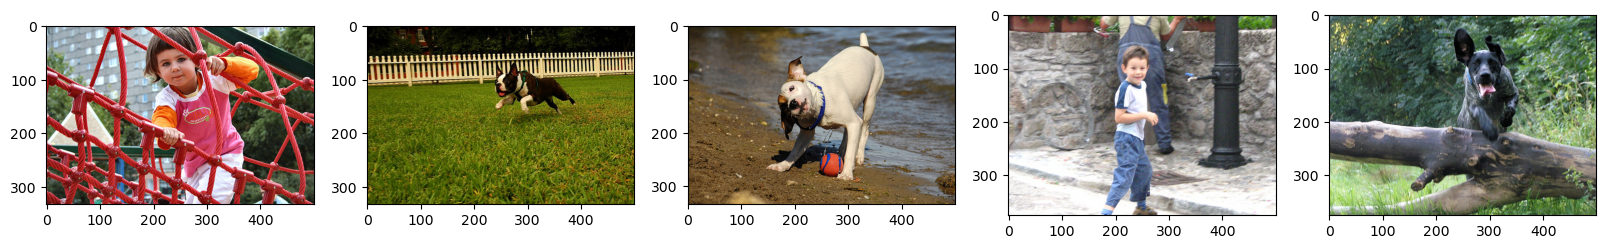

In [4]:
Display_Images= all_imgs[5:10]
figure, axes = plt.subplots(1,5)
figure.set_figwidth(20)
   
for ax,image in zip(axes, Display_Images):
    ax.imshow(io.imread(image), cmap=None)

# Import the dataset and read the text file into a seperate variable

In [5]:

text_file = './CaptionDataSet_1000/captions.txt'
def load_doc(filename):
    
    #your code here
    open_file = open(text_file, 'r', encoding="latin-1") #associate and returns a file object
    text = open_file.read() #for reading the content of the file    
    open_file.close()    
    return text

doc = load_doc(text_file)
print(doc[:1000])

image,caption
1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg,A girl going into a wooden building .
1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .
1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting
1001773457_577c3a7d70.jpg,A black dog and a tri-colored dog playing with each other on the road .
1001773457_577c3a7d70.jpg,A black dog and a white dog with brown spots are staring at each other in the street .
1001773457_577c3a7d70.jpg,Two dogs of different breeds looking at each other on the road .
1001773457_577c3a7d70.jpg,Two dogs on pavement moving toward each other .
1002674143_1b742ab4b8.jpg,A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .
1002674143_1b742ab4b8

In [6]:
image_path='./CaptionDataSet_1000/images/'
all_img_id= [] #store all the image id here
all_img_vector=[] #store all the image path here
annotations=[] #store all the captions here
with open('./CaptionDataSet_1000/captions.txt', 'r') as fo:
    next(fo) # to skip the heading 
    for line in fo:
        split_arr=line.split(',')
        all_img_id.append(split_arr[0])
        annotations.append(split_arr[1].rstrip('\n.')) #striping \n and fullstop
        all_img_vector.append(image_path+split_arr[0])
df = pd.DataFrame(list(zip(all_img_id, all_img_vector,annotations)),columns =['ID','Path', 'Captions']) 
    
df

ID  \
0     1000268201_693b08cb0e.jpg   
1     1000268201_693b08cb0e.jpg   
2     1000268201_693b08cb0e.jpg   
3     1000268201_693b08cb0e.jpg   
4     1000268201_693b08cb0e.jpg   
...                         ...   
4995  2098418613_85a0c9afea.jpg   
4996  2098418613_85a0c9afea.jpg   
4997  2098418613_85a0c9afea.jpg   
4998  2098418613_85a0c9afea.jpg   
4999  2098418613_85a0c9afea.jpg   

                                                   Path  \
0     ./CaptionDataSet_1000/images/1000268201_693b08...   
1     ./CaptionDataSet_1000/images/1000268201_693b08...   
2     ./CaptionDataSet_1000/images/1000268201_693b08...   
3     ./CaptionDataSet_1000/images/1000268201_693b08...   
4     ./CaptionDataSet_1000/images/1000268201_693b08...   
...                                                 ...   
4995  ./CaptionDataSet_1000/images/2098418613_85a0c9...   
4996  ./CaptionDataSet_1000/images/2098418613_85a0c9...   
4997  ./CaptionDataSet_1000/images/2098418613_85a0c9...   
4998  ./CaptionDataSet_1000/images/2098418613_85a0c9...   
4999  ./CaptionDataSet_1000/images/2098418613_85a0c9...   

                                               Captions  
0     A child in a pink dress is climbing up a set o...  
1                  A girl going into a wooden building   
2       A little girl climbing into a wooden playhouse   
3     A little girl climbing the stairs to her playh...  
4     A little girl in a pink dress going into a woo...  
...                                                 ...  
4995  A brown chow mix dog is standing in front of a...  
4996              A brown dog standing in a muddy yard   
4997  A brown dogs walks near a green van and some j...  
4998  A large brown dog stands in front of a green v...  
4999  A yellow dog is standing in front of a green c...  

[5000 rows x 3 columns]

In [7]:
type(annotations)


list

In [8]:
len(annotations)

5000

# Create a list which contains all the captions

In [9]:
annotations=['<start>' + ' ' +  line + ' ' + '<end>' for line in annotations] 

#add the <start> & <end> token to all those captions as well

#Create a list which contains all the path to the images
all_img_path=all_img_vector

print("Total captions present in the dataset: "+ str(len(annotations)))
print("Total images present in the dataset: " + str(len(all_img_path)))

Total captions present in the dataset: 5000
Total images present in the dataset: 5000


In [10]:
annotations[0:5]

['<start> A child in a pink dress is climbing up a set of stairs in an entry way  <end>',
 '<start> A girl going into a wooden building  <end>',
 '<start> A little girl climbing into a wooden playhouse  <end>',
 '<start> A little girl climbing the stairs to her playhouse  <end>',
 '<start> A little girl in a pink dress going into a wooden cabin  <end>']

# Create the vocabulary & the counter for the captions

In [11]:


vocabulary= [word for line in annotations for word in line.split()] 

val_count=Counter(vocabulary)
val_count

Counter({'<start>': 5000,
         'A': 2762,
         'child': 232,
         'in': 2207,
         'a': 4989,
         'pink': 100,
         'dress': 43,
         'is': 1166,
         'climbing': 113,
         'up': 196,
         'set': 12,
         'of': 824,
         'stairs': 7,
         'an': 241,
         'entry': 1,
         'way': 12,
         '<end>': 5000,
         'girl': 462,
         'going': 17,
         'into': 175,
         'wooden': 43,
         'building': 39,
         'little': 271,
         'playhouse': 2,
         'the': 1787,
         'to': 456,
         'her': 155,
         'cabin': 1,
         'black': 423,
         'dog': 1042,
         'and': 1045,
         'spotted': 6,
         'are': 361,
         'fighting': 11,
         'tri-colored': 4,
         'playing': 217,
         'with': 961,
         'each': 56,
         'other': 84,
         'on': 1340,
         'road': 58,
         'white': 397,
         'brown': 298,
         'spots': 4,
         'staring': 5,


# Visualise the top 30 occuring words in the captions

<start> :  5000
<end> :  5000
a :  4989
A :  2762
in :  2207
the :  1787
on :  1340
is :  1166
and :  1045
dog :  1042
with :  961
man :  908
of :  824
boy :  511
Two :  472
girl :  462
to :  456
black :  423
water :  401
white :  397
woman :  392
at :  382
wearing :  368
are :  361
The :  360
young :  330
his :  316
brown :  298
red :  289
blue :  279


Text(0, 0.5, 'Counts')

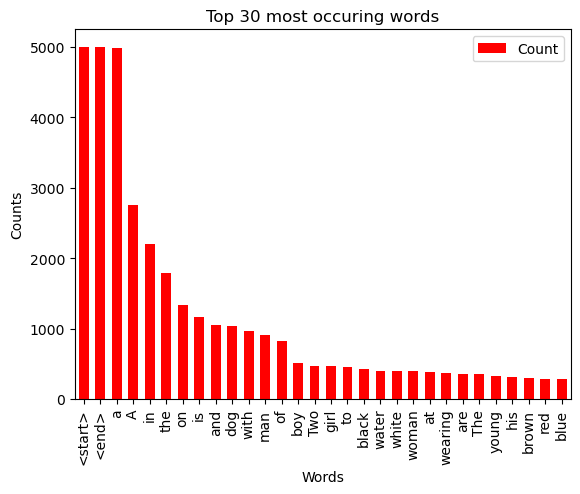

In [12]:

for word, count in val_count.most_common(30):
    print(word, ": ", count)

lst = val_count.most_common(30)
most_common_words_df = pd.DataFrame(lst, columns = ['Word', 'Count'])
most_common_words_df.plot.bar(x='Word',y='Count',width=0.6,color='red')
plt.title("Top 30 most occuring words")
plt.xlabel("Words")
plt.ylabel("Counts")

# create the tokenizer

In [80]:


top_word_count = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_word_count+1,oov_token="<unk>",filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(annotations)
train_seqs = tokenizer.texts_to_sequences(annotations)
tokenizer_path = './FinalModels/tokenizer.pkl'
with open(tokenizer_path, 'wb') as tokenizer_file:
    pickle.dump(tokenizer, tokenizer_file)

# Create word-to-index and index-to-word mappings.

In [14]:


tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [15]:
train_seqs[:5]

[[3, 2, 38, 5, 2, 79, 165, 8, 71, 42, 2, 420, 13, 620, 5, 30, 1764, 421, 4],
 [3, 2, 16, 317, 49, 2, 166, 179, 4],
 [3, 2, 31, 16, 71, 49, 2, 166, 1306, 4],
 [3, 2, 31, 16, 71, 6, 620, 17, 59, 1306, 4],
 [3, 2, 31, 16, 5, 2, 79, 165, 317, 49, 2, 166, 1765, 4]]

In [16]:
annotations[:5]

['<start> A child in a pink dress is climbing up a set of stairs in an entry way  <end>',
 '<start> A girl going into a wooden building  <end>',
 '<start> A little girl climbing into a wooden playhouse  <end>',
 '<start> A little girl climbing the stairs to her playhouse  <end>',
 '<start> A little girl in a pink dress going into a wooden cabin  <end>']

In [17]:
tokenizer.oov_token

'<unk>'

In [18]:
tokenizer.index_word

{1: '<unk>',
 2: 'a',
 3: '<start>',
 4: '<end>',
 5: 'in',
 6: 'the',
 7: 'on',
 8: 'is',
 9: 'dog',
 10: 'and',
 11: 'man',
 12: 'with',
 13: 'of',
 14: 'two',
 15: 'boy',
 16: 'girl',
 17: 'to',
 18: 'black',
 19: 'woman',
 20: 'white',
 21: 'water',
 22: 'at',
 23: 'wearing',
 24: 'are',
 25: 'young',
 26: 'his',
 27: 'people',
 28: 'brown',
 29: 'red',
 30: 'an',
 31: 'little',
 32: 'blue',
 33: 'down',
 34: 'standing',
 35: 'through',
 36: 'dogs',
 37: 'shirt',
 38: 'child',
 39: 'running',
 40: 'while',
 41: 'playing',
 42: 'up',
 43: 'three',
 44: 'grass',
 45: 'person',
 46: 'front',
 47: 'sitting',
 48: 'small',
 49: 'into',
 50: 'beach',
 51: 'walking',
 52: 'green',
 53: 'children',
 54: 'rock',
 55: 'jumping',
 56: 'ball',
 57: 'field',
 58: 'large',
 59: 'her',
 60: 'by',
 61: 'near',
 62: 'stands',
 63: 'holding',
 64: 'over',
 65: 'yellow',
 66: 'next',
 67: 'snow',
 68: 'from',
 69: 'mouth',
 70: 'group',
 71: 'climbing',
 72: 'out',
 73: 'girls',
 74: 'its',
 75: 'str

In [19]:
tokenizer.word_counts

OrderedDict([('<start>', 5000),
             ('a', 7890),
             ('child', 238),
             ('in', 2208),
             ('pink', 101),
             ('dress', 43),
             ('is', 1166),
             ('climbing', 114),
             ('up', 200),
             ('set', 12),
             ('of', 824),
             ('stairs', 7),
             ('an', 291),
             ('entry', 1),
             ('way', 12),
             ('<end>', 5000),
             ('girl', 475),
             ('going', 17),
             ('into', 175),
             ('wooden', 43),
             ('building', 39),
             ('little', 288),
             ('playhouse', 2),
             ('the', 2172),
             ('to', 456),
             ('her', 155),
             ('cabin', 1),
             ('black', 442),
             ('dog', 1057),
             ('and', 1045),
             ('spotted', 6),
             ('are', 361),
             ('fighting', 11),
             ('tri', 4),
             ('colored', 35),
             ('p

# Create a word count of tokenizer to visulize the Top 30 occuring words after text processing

In [20]:
def get_top_words_based_on_cnt(words_dict,n_words):
    n_words+=1
    keys=list(words_dict.keys())
    values=list(words_dict.values())
    sorted_values=sorted(values,reverse=True)[:n_words]
    sorted_keys=[]
    for i in sorted_values:
        if sorted_values.count(i)==1:
            sorted_keys.append(keys[values.index(i)])
        elif sorted_values.count(i)==2:
            f_idx=values.index(i)
            s_idx=values[f_idx+1:].index(i)
            s_idx+=f_idx+1
            a,b=keys[f_idx],keys[s_idx]
            if a not in sorted_keys and b not in sorted_keys:
                sorted_keys.append(a)
                sorted_keys.append(b)
    plt.figure(figsize=(10,6))
    sns.barplot(x=sorted_keys,y=sorted_values)
    plt.xticks(rotation=60)
    plt.show()

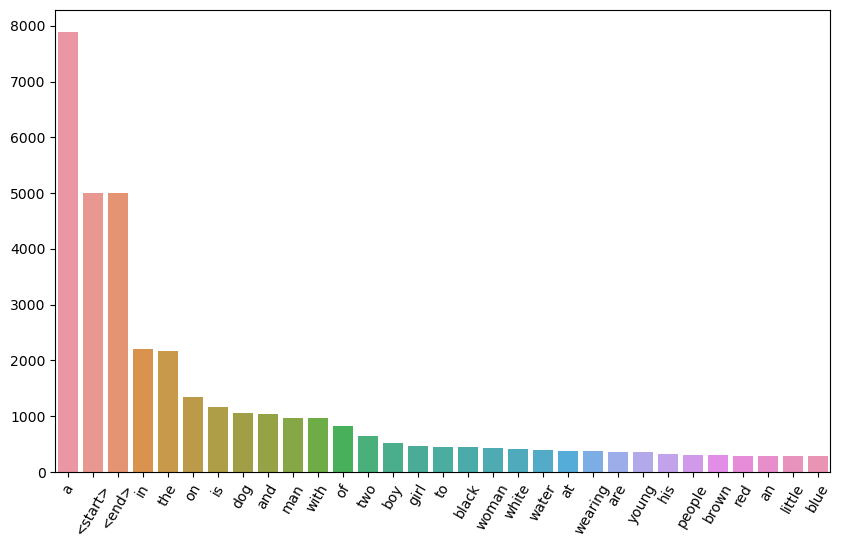

In [21]:
get_top_words_based_on_cnt(tokenizer.word_counts,30)

In [22]:
def caption_and_image_plotter(image_id,frame):
    #get captions
    caps=("\n"*2).join(frame[frame['ID']==image_id].Captions.to_list())
    fig, ax = plt.subplots()
    ax.set_axis_off()
    idx=df.ID.to_list().index(image_id)
    im=Image.open(df.Path.iloc[idx])
    w,h=im.size[0],im.size[-1]
    ax.imshow(im)
    ax.text(w+50,h,caps,fontsize=20,color='blue')

In [23]:
def run_caption_and_image_plotter_for_a_range(start,end,frame):
    for i in range(start,end):
        caption_and_image_plotter(frame.ID.drop_duplicates().iloc[i],frame)


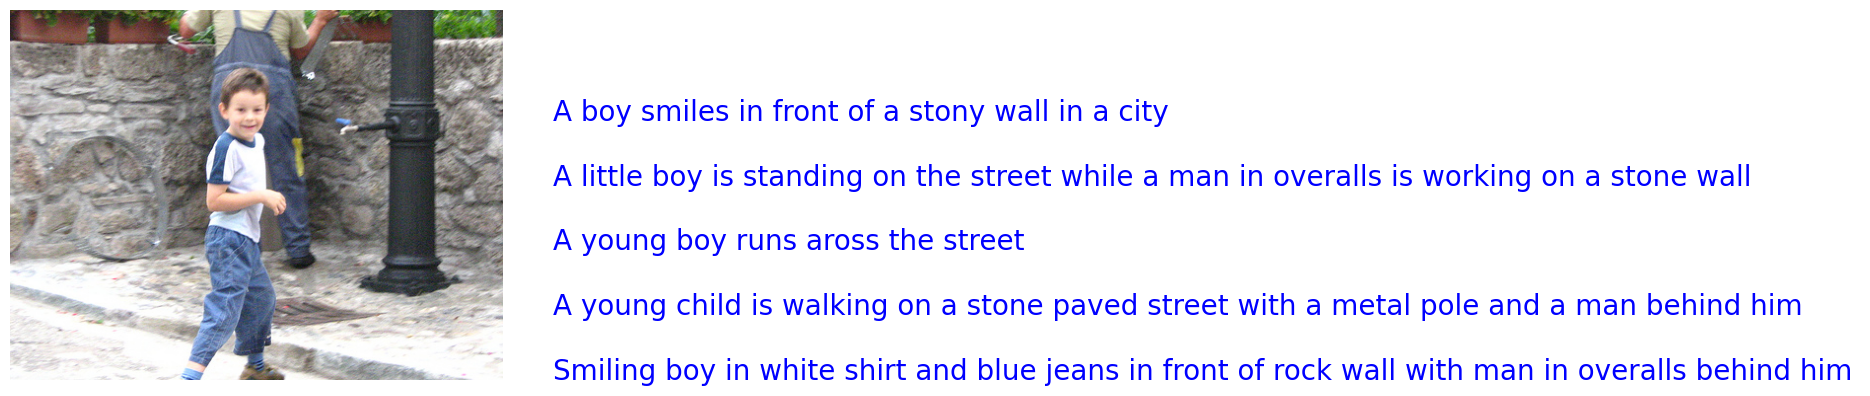

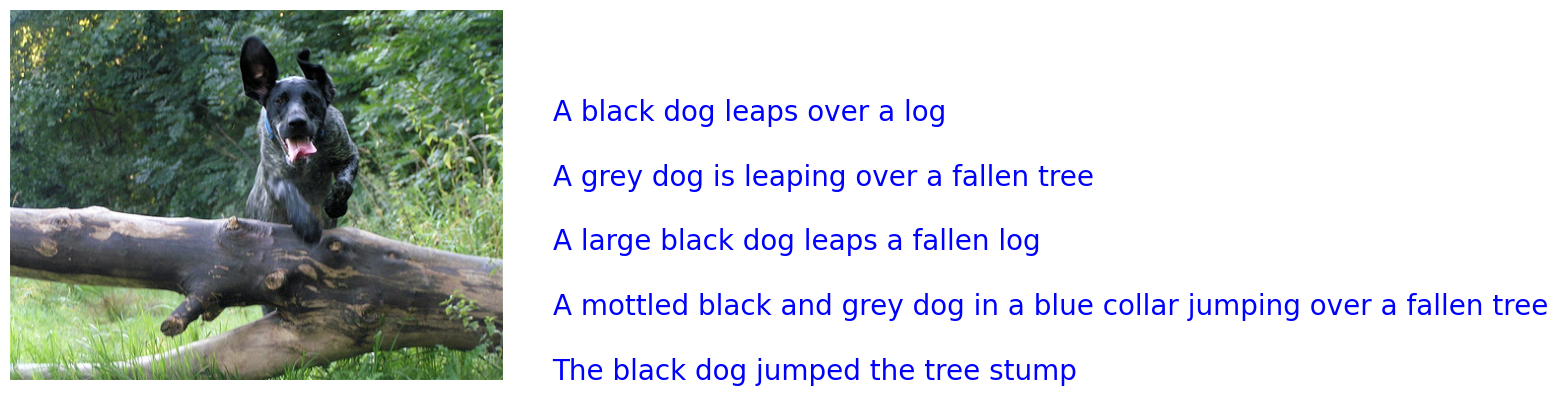

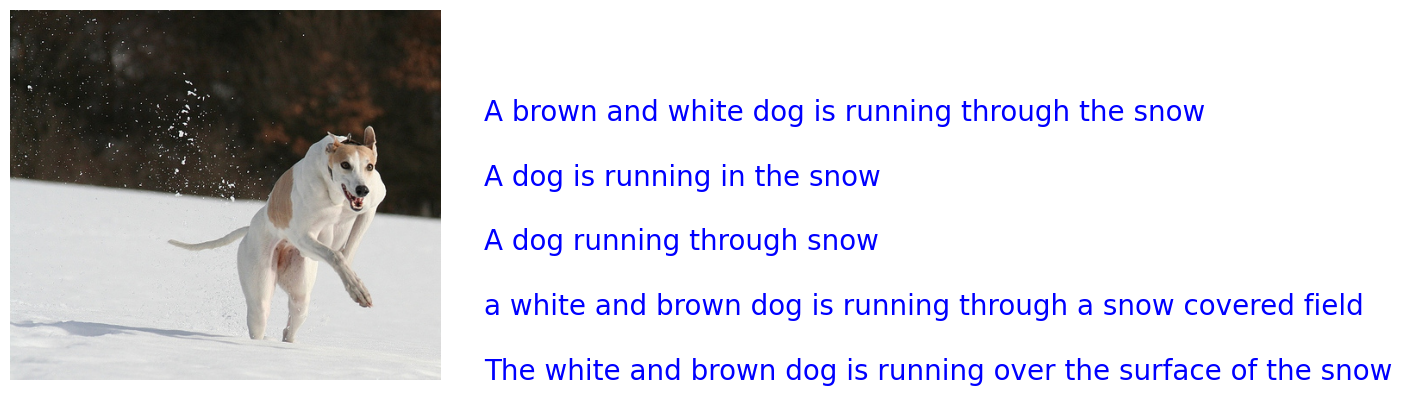

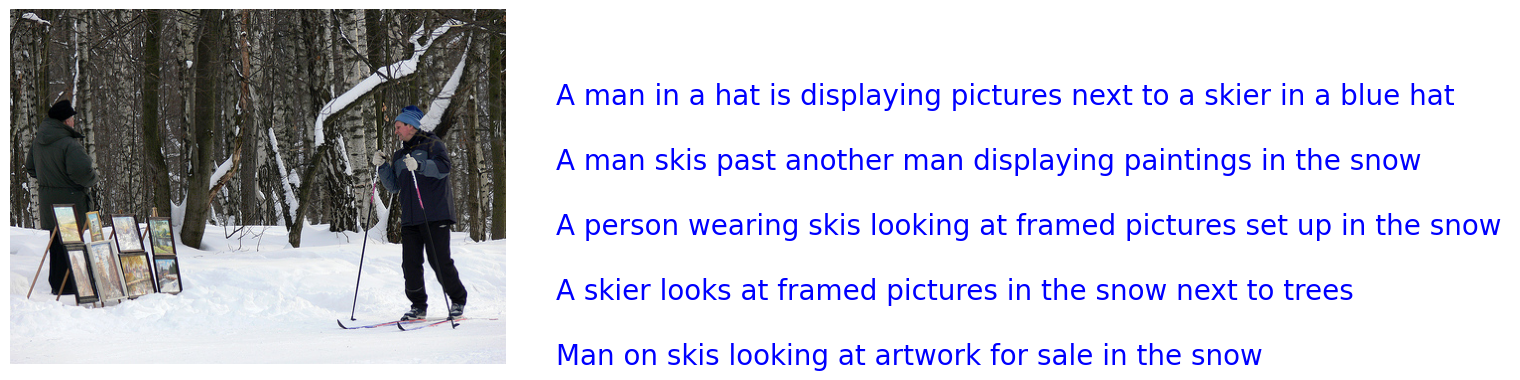

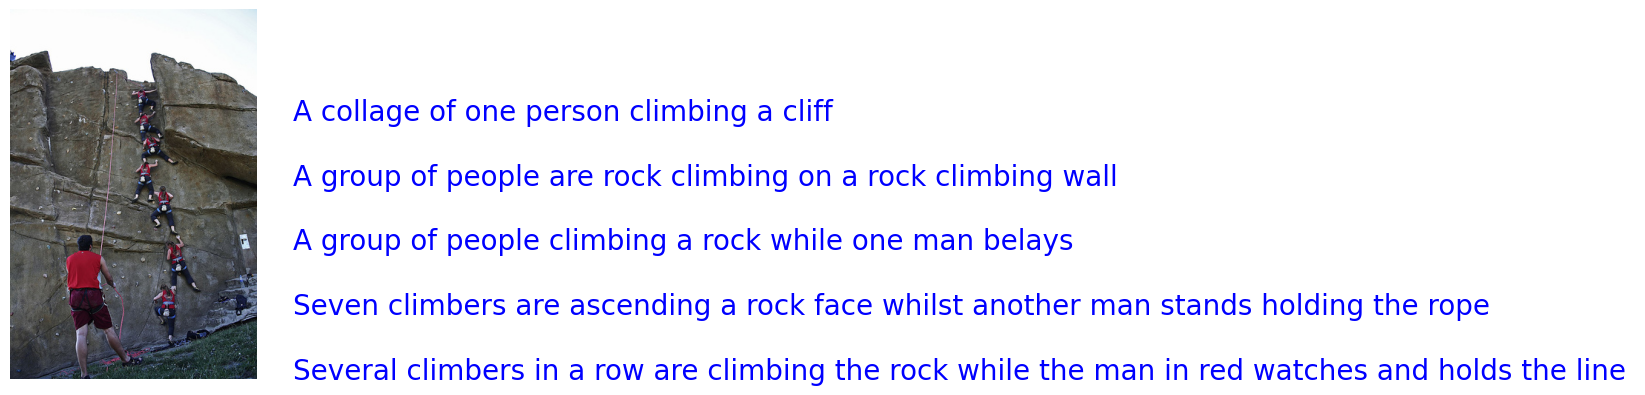

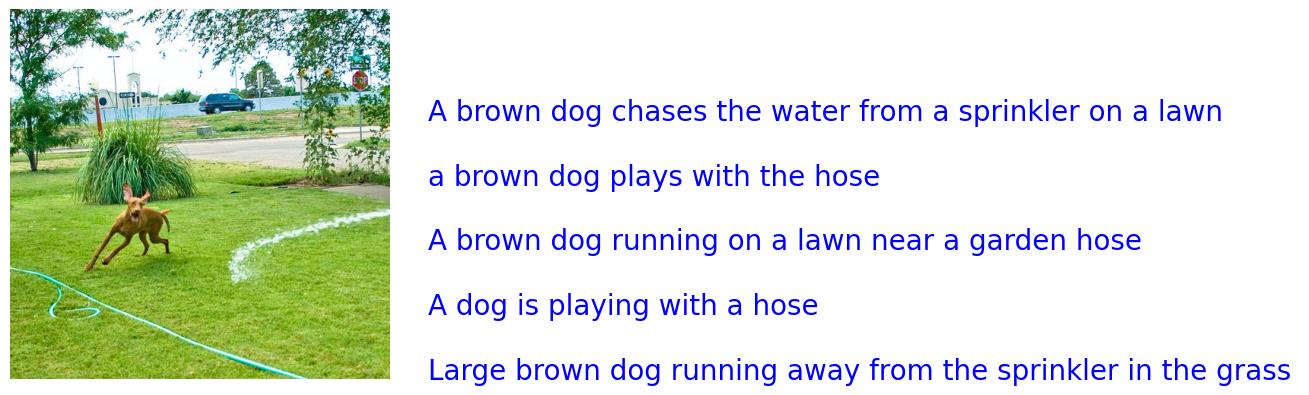

In [24]:
run_caption_and_image_plotter_for_a_range(8,14,df)

# Function to find the maximum length of any caption in our dataset

In [25]:
def calc_max_length(tensor):
    return max(len(t) for t in tensor)
# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs)
max_l= max_length

In [78]:
print('max_l',max_l)

max_l 35


# Pad each vector to the max_length of the captions store it to a vairable

In [26]:
def padding_train_sequences(train_seqs,max_length,padding_type):
  cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding=padding_type,maxlen=max_length)
  return cap_vector
caption_vector= padding_train_sequences(train_seqs,max_length,'post')

print("The shape of Caption vector is :" + str(caption_vector.shape))

The shape of Caption vector is :(5000, 35)


In [27]:
caption_vector

array([[ 3,  2, 38, ...,  0,  0,  0],
       [ 3,  2, 16, ...,  0,  0,  0],
       [ 3,  2, 31, ...,  0,  0,  0],
       ...,
       [ 3,  2, 28, ...,  0,  0,  0],
       [ 3,  2, 58, ...,  0,  0,  0],
       [ 3,  2, 65, ...,  0,  0,  0]])

# Pre-processing the images

## Resizing each image into the shape of (299, 299)

In [28]:
def load_image(image_path):    
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)    
    return img, image_path

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


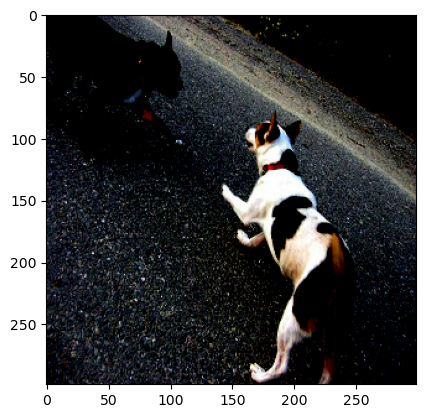

In [29]:
plt.imshow(load_image(all_img_path[8])[0])

In [30]:
encode_train_set = sorted(set(all_img_vector))

feature_dict = {}

image_data_set = tf.data.Dataset.from_tensor_slices(encode_train_set)
image_data_set = image_data_set.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(32)

In [31]:
image_data_set

<_BatchDataset element_spec=(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None))>

# Loading the pretrained Imagenet weights of Inception net V3

In [32]:
image_model = tf.keras.applications.InceptionV3(include_top=False,weights='imagenet')

new_input = image_model.input 
hidden_layer = image_model.layers[-1].output 

image_features_extract_model =keras.Model(new_input, hidden_layer) #build the final model using both input & output layer

In [33]:
image_features_extract_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 alization)                     32)                                                           

                                                                                                  
 average_pooling2d (AveragePool  (None, None, None,   0          ['max_pooling2d_1[0][0]']        
 ing2D)                         192)                                                              
                                                                                                  
 conv2d_5 (Conv2D)              (None, None, None,   12288       ['max_pooling2d_1[0][0]']        
                                64)                                                               
                                                                                                  
 conv2d_7 (Conv2D)              (None, None, None,   76800       ['activation_6[0][0]']           
                                64)                                                               
                                                                                                  
 conv2d_10

                                                                                                  
 conv2d_18 (Conv2D)             (None, None, None,   16384       ['average_pooling2d_1[0][0]']    
                                64)                                                               
                                                                                                  
 batch_normalization_12 (BatchN  (None, None, None,   192        ['conv2d_12[0][0]']              
 ormalization)                  64)                                                               
                                                                                                  
 batch_normalization_14 (BatchN  (None, None, None,   192        ['conv2d_14[0][0]']              
 ormalization)                  64)                                                               
                                                                                                  
 batch_nor

                                                                                                  
 batch_normalization_25 (BatchN  (None, None, None,   192        ['conv2d_25[0][0]']              
 ormalization)                  64)                                                               
                                                                                                  
 activation_19 (Activation)     (None, None, None,   0           ['batch_normalization_19[0][0]'] 
                                64)                                                               
                                                                                                  
 activation_21 (Activation)     (None, None, None,   0           ['batch_normalization_21[0][0]'] 
                                64)                                                               
                                                                                                  
 activatio

                                128)                                                              
                                                                                                  
 conv2d_36 (Conv2D)             (None, None, None,   114688      ['activation_35[0][0]']          
                                128)                                                              
                                                                                                  
 batch_normalization_31 (BatchN  (None, None, None,   384        ['conv2d_31[0][0]']              
 ormalization)                  128)                                                              
                                                                                                  
 batch_normalization_36 (BatchN  (None, None, None,   384        ['conv2d_36[0][0]']              
 ormalization)                  128)                                                              
          

 ormalization)                  160)                                                              
                                                                                                  
 activation_44 (Activation)     (None, None, None,   0           ['batch_normalization_44[0][0]'] 
                                160)                                                              
                                                                                                  
 conv2d_45 (Conv2D)             (None, None, None,   179200      ['activation_44[0][0]']          
                                160)                                                              
                                                                                                  
 batch_normalization_45 (BatchN  (None, None, None,   480        ['conv2d_45[0][0]']              
 ormalization)                  160)                                                              
          

 activation_48 (Activation)     (None, None, None,   0           ['batch_normalization_48[0][0]'] 
                                192)                                                              
                                                                                                  
 activation_49 (Activation)     (None, None, None,   0           ['batch_normalization_49[0][0]'] 
                                192)                                                              
                                                                                                  
 mixed5 (Concatenate)           (None, None, None,   0           ['activation_40[0][0]',          
                                768)                              'activation_43[0][0]',          
                                                                  'activation_48[0][0]',          
                                                                  'activation_49[0][0]']          
          

 batch_normalization_53 (BatchN  (None, None, None,   576        ['conv2d_53[0][0]']              
 ormalization)                  192)                                                              
                                                                                                  
 batch_normalization_58 (BatchN  (None, None, None,   576        ['conv2d_58[0][0]']              
 ormalization)                  192)                                                              
                                                                                                  
 batch_normalization_59 (BatchN  (None, None, None,   576        ['conv2d_59[0][0]']              
 ormalization)                  192)                                                              
                                                                                                  
 activation_50 (Activation)     (None, None, None,   0           ['batch_normalization_50[0][0]'] 
          

 conv2d_60 (Conv2D)             (None, None, None,   147456      ['mixed6[0][0]']                 
                                192)                                                              
                                                                                                  
 conv2d_63 (Conv2D)             (None, None, None,   258048      ['activation_62[0][0]']          
                                192)                                                              
                                                                                                  
 conv2d_68 (Conv2D)             (None, None, None,   258048      ['activation_67[0][0]']          
                                192)                                                              
                                                                                                  
 conv2d_69 (Conv2D)             (None, None, None,   147456      ['average_pooling2d_6[0][0]']    
          

 batch_normalization_71 (BatchN  (None, None, None,   960        ['conv2d_71[0][0]']              
 ormalization)                  320)                                                              
                                                                                                  
 batch_normalization_75 (BatchN  (None, None, None,   576        ['conv2d_75[0][0]']              
 ormalization)                  192)                                                              
                                                                                                  
 activation_71 (Activation)     (None, None, None,   0           ['batch_normalization_71[0][0]'] 
                                320)                                                              
                                                                                                  
 activation_75 (Activation)     (None, None, None,   0           ['batch_normalization_75[0][0]'] 
          

                                384)                                                              
                                                                                                  
 activation_79 (Activation)     (None, None, None,   0           ['batch_normalization_79[0][0]'] 
                                384)                                                              
                                                                                                  
 activation_82 (Activation)     (None, None, None,   0           ['batch_normalization_82[0][0]'] 
                                384)                                                              
                                                                                                  
 activation_83 (Activation)     (None, None, None,   0           ['batch_normalization_83[0][0]'] 
                                384)                                                              
          

 ormalization)                  384)                                                              
                                                                                                  
 batch_normalization_92 (BatchN  (None, None, None,   1152       ['conv2d_92[0][0]']              
 ormalization)                  384)                                                              
                                                                                                  
 conv2d_93 (Conv2D)             (None, None, None,   393216      ['average_pooling2d_8[0][0]']    
                                192)                                                              
                                                                                                  
 batch_normalization_85 (BatchN  (None, None, None,   960        ['conv2d_85[0][0]']              
 ormalization)                  320)                                                              
          

In [34]:
# Once the features are created, you need to reshape them such that feature shape is in order of (batch_size, 8*8, 2048)
for image,path in tqdm(image_data_set):
    batch_features = image_features_extract_model(image)
    batch_features = tf.reshape(batch_features,(batch_features.shape[0], -1, batch_features.shape[3]))
    for batch_f, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        feature_dict[path_of_feature] =  batch_f.numpy()

100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [01:58<00:00,  3.71s/it]


In [35]:
batch_f.shape

TensorShape([64, 2048])

# Dataset creation

In [36]:
path_train, path_test, cap_train, cap_test = train_test_split(all_img_vector,caption_vector,test_size=0.2,random_state=42)

In [37]:
print("Training data for images: " + str(len(path_train)))
print("Testing data for images: " + str(len(path_test)))
print("Training data for Captions: " + str(len(cap_train)))
print("Testing data for Captions: " + str(len(cap_test)))

Training data for images: 4000
Testing data for images: 1000
Training data for Captions: 4000
Testing data for Captions: 1000


In [38]:
# Create a function which maps the image path to their feature. 
# This function will take the image_path & caption and return it's feature & respective caption.

def map_func(image_name,capt): 
  img_tensor = feature_dict[image_name.decode('utf-8')] 
  return img_tensor,capt

# load the features

In [39]:
# create a builder function to create dataset which takes in the image path & captions as input
# This function should transform the created dataset(img_path,cap) to (features,cap) using the map_func created earlier
BATCH_SIZE = 32
BUFFER_SIZE = 1000
def gen_dataset(images_data, captions_data): #your input variables):
    
    # your code goes here to create the dataset & transform it
    dataset = tf.data.Dataset.from_tensor_slices((images_data, captions_data))
    dataset = dataset.shuffle(BUFFER_SIZE)

    dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(BATCH_SIZE)


    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

In [40]:
train_dataset=gen_dataset(path_train,cap_train)
test_dataset=gen_dataset(path_test,cap_test)

In [41]:
sample_img_batch, sample_cap_batch = next(iter(train_dataset))
print(sample_img_batch.shape)  #(batch_size, 8*8, 2048)
print(sample_cap_batch.shape) #(batch_size,max_len)

(32, 64, 2048)
(32, 35)


# Model Building

In [42]:
embedding_dim = 256 
units = 512
vocab_size = 5001 #top 5,000 words +1
train_num_steps = len(path_train) // BATCH_SIZE #len(total train images) // BATCH_SIZE
test_num_steps = len(path_test) // BATCH_SIZE #len(total test images) // BATCH_SIZE

# Encoder

In [46]:
class Encoder(Model):
    def __init__(self,embed_dim):
        super(Encoder, self).__init__()
        #self.dense = #build  Dense layer with relu activation
        self.fc = layers.Dense(embed_dim)
        self.dropout = layers.Dropout(0.5)        
    def call(self, features):
        features = self.fc(features)  # extract the features from the image shape: (batch, 8*8, embed_dim)
        features = tf.nn.relu(features)
        return features

In [47]:
encoder=Encoder(embedding_dim)

# Attention model

In [48]:
class Attention_model(Model):
    def __init__(self, units):
        super(Attention_model, self).__init__()
        self.W1 =layers.Dense(units) #build Dense layer
        self.W2 = layers.Dense(units) #build Dense layer
        self.V = layers.Dense(1) #build final Dense layer with unit 1
        self.units=units

    def call(self, features, hidden):
        #features shape: (batch_size, 8*8, embedding_dim)
        # hidden shape: (batch_size, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, 1) # Expand the hidden shape to shape: (batch_size, 1, hidden_size)
        score =  keras.activations.tanh(self.W1(features) + self.W2(hidden_with_time_axis))  # build score funciton to shape: (batch_size, 8*8, units)
        attention_weights = keras.activations.softmax(self.V(score), axis=1) # extract attention weights with shape: (batch_size, 8*8, 1)
        context_vector = attention_weights * features #shape: create the context vector with shape (batch_size, 8*8,embedding_dim)
        context_vector = tf.reduce_sum(context_vector, axis=1) # reduce the shape to (batch_size, embedding_dim)
        

        return context_vector, attention_weights

# Decoder

In [49]:
class Decoder(Model):
    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units=units
        self.attention = Attention_model(self.units) #iniitalise Attention model with units
        self.embed = layers.Embedding(vocab_size, embed_dim,mask_zero=False)  #build Embedding layer
        self.gru = tf.keras.layers.GRU(self.units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform')
        self.d1 = layers.Dense(self.units) #build Dense layer
        self.d2 = layers.Dense(vocab_size) #build Dense layer
        self.dropout = Dropout(0.5)

    def call(self,x,features, hidden):
        context_vector, attention_weights = self.attention(features, hidden) #create context vector & attention weights from attention model
        embed = self.dropout(self.embed(x))  # embed input to shape: (batch_size, 1, embedding_dim)
        mask = self.embed.compute_mask(x)
        embed = tf.concat([tf.expand_dims(context_vector, 1), embed], axis=-1)  # Concatenate input with the context vector from attention layer. Shape: (batch_size, 1, embedding_dim + embedding_dim)
        output,state =self.gru(embed,mask=mask) # Extract the output & hidden state from GRU layer. Output shape : (batch_size, max_length, hidden_size)
        output = self.d1(output)
        output = tf.reshape(output, (-1, output.shape[2])) # shape : (batch_size * max_length, hidden_size)
        output = self.d2(output) # shape : (batch_size * max_length, vocab_size)
        
        return output,state, attention_weights
    
    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [52]:
decoder=Decoder(embedding_dim, units, vocab_size)

In [53]:
features=encoder(sample_img_batch)

hidden = decoder.init_state(batch_size=sample_cap_batch.shape[0])
dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * sample_cap_batch.shape[0], 1)

predictions, hidden_out, attention_weights= decoder(dec_input, features, hidden)
print('Feature shape from Encoder: {}'.format(features.shape)) #(batch, 8*8, embed_dim)
print('Predcitions shape from Decoder: {}'.format(predictions.shape)) #(batch,vocab_size)
print('Attention weights shape from Decoder: {}'.format(attention_weights.shape)) #(batch, 8*8, embed_dim)

Feature shape from Encoder: (32, 64, 256)
Predcitions shape from Decoder: (32, 5001)
Attention weights shape from Decoder: (32, 64, 1)


# Model training & optimization

In [54]:
optimizer = tf.keras.optimizers.Adam() #define the optimizer
loss_object = keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none') #define loss object

In [55]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [57]:
INPUT_PATH='./Capstone/'
checkpoint_path_ckpt = INPUT_PATH +'checkpoint1/'
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path_ckpt, max_to_keep=5)

In [58]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

In [59]:
def train_step(img_tensor, target):
    loss = 0
    #hidden = decoder.reset_state(batch_size=target.shape[0])
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    
    with tf.GradientTape() as tape:      
        features = encoder(img_tensor)

        for i in range(1, target.shape[1]):
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_function(target[:, i], predictions)
            dec_input = tf.expand_dims(target[:, i], 1)
        
    avg_loss = (loss / int(target.shape[1]))

    trainable_variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(gradients, trainable_variables))        
    return loss, avg_loss

In [60]:
def test_step(img_tensor, target):
    loss = 0
    
   
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

    with tf.GradientTape() as tape:
        features = encoder(img_tensor)

        for i in range(1, target.shape[1]):
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_function(target[:, i], predictions)
            dec_input = tf.expand_dims(target[:, i], 1)
        
    avg_loss = (loss / int(target.shape[1]))

    trainable_variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(gradients, trainable_variables))        
    return loss, avg_loss

In [61]:
def test_loss_cal(test_dataset):
    total_loss = 0

   
    for (batch, (img_tensor, target)) in enumerate(test_dataset):
        batch_loss, t_loss = test_step(img_tensor, target)
    
        total_loss += t_loss
        avg_test_loss=total_loss/test_num_steps    
    return avg_test_loss

In [64]:
loss_plot = []
test_loss_plot = []
EPOCHS = 15

best_test_loss=100
for epoch in tqdm(range(0, EPOCHS)):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        avg_train_loss=total_loss / train_num_steps
        
    loss_plot.append(avg_train_loss)    
    test_loss = test_loss_cal(test_dataset)
    test_loss_plot.append(test_loss)
    
    
    print ('For epoch: {}, the train loss is {:.3f}, & test loss is {:.3f}'.format(epoch+1,avg_train_loss,test_loss))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    
    if test_loss < best_test_loss:
        print('Test loss has been reduced from %.3f to %.3f' % (best_test_loss, test_loss))
        best_test_loss = test_loss
        ckpt_manager.save()
# Save the encoder model after training
encoder.save('./FinalModels' + '/encoder_model')

# Save the decoder model after training
decoder.save('./FinalModels' + '/decoder_model')

  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

For epoch: 1, the train loss is 1.743, & test loss is 1.580
Time taken for 1 epoch 451.398161649704 sec

Test loss has been reduced from 100.000 to 1.580


  7%|█████▎                                                                          | 1/15 [07:33<1:45:52, 453.78s/it]

For epoch: 2, the train loss is 1.337, & test loss is 1.302
Time taken for 1 epoch 438.72157168388367 sec

Test loss has been reduced from 1.580 to 1.302


 13%|██████████▋                                                                     | 2/15 [14:53<1:36:30, 445.41s/it]

For epoch: 3, the train loss is 1.167, & test loss is 1.157
Time taken for 1 epoch 427.78349471092224 sec

Test loss has been reduced from 1.302 to 1.157


 20%|████████████████                                                                | 3/15 [22:02<1:27:33, 437.83s/it]

For epoch: 4, the train loss is 1.052, & test loss is 1.036
Time taken for 1 epoch 425.78916668891907 sec

Test loss has been reduced from 1.157 to 1.036


 27%|█████████████████████▎                                                          | 4/15 [29:08<1:19:27, 433.41s/it]

For epoch: 5, the train loss is 0.949, & test loss is 0.939
Time taken for 1 epoch 430.7700755596161 sec

Test loss has been reduced from 1.036 to 0.939


 33%|██████████████████████████▋                                                     | 5/15 [36:20<1:12:07, 432.75s/it]

For epoch: 6, the train loss is 0.860, & test loss is 0.850
Time taken for 1 epoch 932.1926825046539 sec

Test loss has been reduced from 0.939 to 0.850


 40%|████████████████████████████████                                                | 6/15 [51:53<1:30:25, 602.85s/it]

For epoch: 7, the train loss is 0.783, & test loss is 0.776
Time taken for 1 epoch 436.5484778881073 sec

Test loss has been reduced from 0.850 to 0.776


 47%|█████████████████████████████████████▎                                          | 7/15 [59:10<1:13:10, 548.77s/it]

For epoch: 8, the train loss is 0.717, & test loss is 0.704
Time taken for 1 epoch 435.1120550632477 sec

Test loss has been reduced from 0.776 to 0.704


 53%|██████████████████████████████████████████▋                                     | 8/15 [1:06:26<59:50, 512.87s/it]

For epoch: 9, the train loss is 0.659, & test loss is 0.650
Time taken for 1 epoch 440.5891547203064 sec

Test loss has been reduced from 0.704 to 0.650


 60%|████████████████████████████████████████████████                                | 9/15 [1:13:50<49:07, 491.18s/it]

For epoch: 10, the train loss is 0.610, & test loss is 0.597
Time taken for 1 epoch 538.6140897274017 sec

Test loss has been reduced from 0.650 to 0.597


 67%|████████████████████████████████████████████████████▋                          | 10/15 [1:22:53<42:16, 507.20s/it]

For epoch: 11, the train loss is 0.564, & test loss is 0.560
Time taken for 1 epoch 485.23131132125854 sec

Test loss has been reduced from 0.597 to 0.560


 73%|█████████████████████████████████████████████████████████▉                     | 11/15 [1:30:59<33:23, 500.81s/it]

For epoch: 12, the train loss is 0.528, & test loss is 0.517
Time taken for 1 epoch 447.0189344882965 sec

Test loss has been reduced from 0.560 to 0.517


 80%|███████████████████████████████████████████████████████████████▏               | 12/15 [1:38:27<24:14, 484.77s/it]

For epoch: 13, the train loss is 0.492, & test loss is 0.479
Time taken for 1 epoch 434.5131540298462 sec

Test loss has been reduced from 0.517 to 0.479


 87%|████████████████████████████████████████████████████████████████████▍          | 13/15 [1:45:43<15:39, 469.80s/it]

For epoch: 14, the train loss is 0.459, & test loss is 0.448
Time taken for 1 epoch 448.19905853271484 sec

Test loss has been reduced from 0.479 to 0.448


 93%|█████████████████████████████████████████████████████████████████████████▋     | 14/15 [1:53:13<07:44, 464.05s/it]

For epoch: 15, the train loss is 0.430, & test loss is 0.419
Time taken for 1 epoch 544.2432069778442 sec

Test loss has been reduced from 0.448 to 0.419


100%|███████████████████████████████████████████████████████████████████████████████| 15/15 [2:02:18<00:00, 489.26s/it]


INFO:tensorflow:Assets written to: ./FinalModels/encoder_model\assets


INFO:tensorflow:Assets written to: ./FinalModels/decoder_model\assets


INFO:tensorflow:Assets written to: ./FinalModels/decoder_model\assets


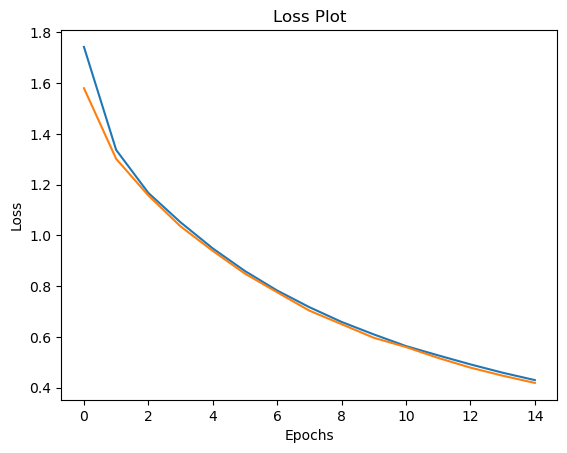

In [66]:
plt.plot(loss_plot)
plt.plot(test_loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

# Model Evaluation

In [65]:
def evaluate(image):
    max_length=max_l
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0) #process the input image to desired format before extracting features
    img_tensor_val = image_features_extract_model(temp_input) # Extract features using our feature extraction model
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val) # extract the features by passing the input to encoder

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden) # get the output from decoder

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()  #extract the predicted id(embedded value) which carries the max value
        result.append(tokenizer.index_word[predicted_id])
        #map the id to the word from tokenizer and append the value to the result list

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot,predictions

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot,predictions


In [67]:
def plot_attmap(caption, weights, image):

    fig = plt.figure(figsize=(10, 10))
    temp_img = np.array(Image.open(image))
    
    len_cap = len(caption)
    for cap in range(len_cap):
        weights_img = np.reshape(weights[cap], (8,8))
        weights_img = np.array(Image.fromarray(weights_img).resize((224, 224), Image.LANCZOS))
        
        ax = fig.add_subplot(len_cap//2, len_cap//2, cap+1)
        ax.set_title(caption[cap], fontsize=15)
        
        img=ax.imshow(temp_img)
        
        ax.imshow(weights_img, cmap='gist_heat', alpha=0.6,extent=img.get_extent())
        ax.axis('off')
    plt.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.show()

In [68]:
def filt_text(text):
    filt=['<start>','<unk>','<end>'] 
    temp= text.split()
    [temp.remove(j) for k in filt for j in temp if k==j]
    text=' '.join(temp)
    return text

In [69]:
features_shape = batch_f.shape[1]
attention_features_shape = batch_f.shape[0]

In [70]:
img_test=path_test.copy()

In [77]:
def predicted_caption_audio(random,autoplay=False,weights=(0.5, 0.5, 0, 0)):

    cap_test_d=cap_test.copy()
    rid = np.random.randint(0, random)
    test_image = img_test[rid]
    #test_image = 'Flickr8K/Images/413231421_43833a11f5.jpg'
    #real_caption = '<start> black dog is digging in the snow <end>'

    real_caption = ' '.join([tokenizer.index_word[i] for i in cap_test[rid] if i not in [0]])
    result, attention_plot,pred_test = evaluate(test_image)

    real_caption=filt_text(real_caption)      

    pred_caption=' '.join(result).rsplit(' ', 1)[0]

    real_appn = []
    real_appn.append(real_caption.split())
    reference = real_appn
    candidate = pred_caption.split()

    score = sentence_bleu(reference, candidate, weights=weights)#set your weights)
    print(f"BELU score: {score*100}")

    print ('Real Caption:', real_caption)
    print ('Prediction Caption:', pred_caption)
    
    plot_attmap(result, attention_plot, test_image)  
    
   
    

    
    
    return test_image

C:\Users\admin\anaconda3\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\admin\AppData\Local\Temp\ipykernel_13912\1530701205.py:9: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  weights_img = np.array(Image.fromarray(weights_img).resize((224, 224), Image.LANCZOS))


BELU score: 20.23098037523463
Real Caption: a dog is digging a large hole in a yard to find something
Prediction Caption: a dog is playing with a leafy ground


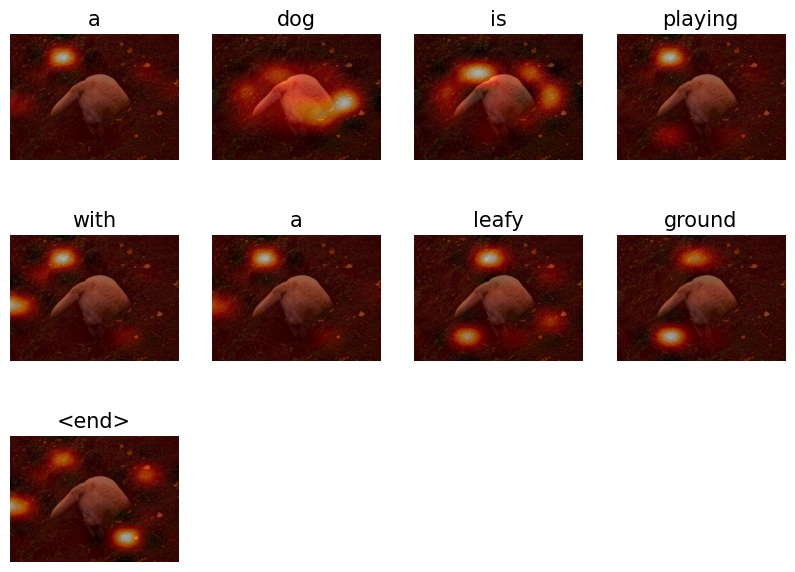

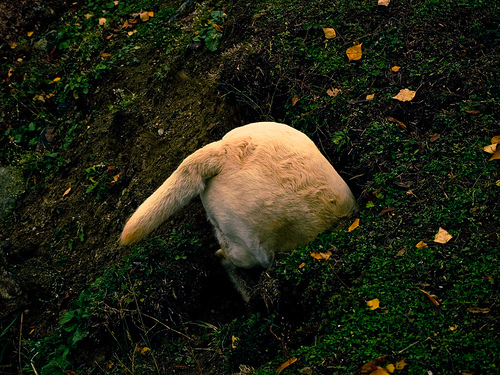

In [76]:
test_image=predicted_caption_audio(len(img_test),True,weights=(0.5,0.5,0,0))
Image.open(test_image)